In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

In [2]:
!wandb disabled

W&B disabled.


In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.9/906.9 kB 28.6 MB/s eta 0:00:00


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.applications import DenseNet121
from keras import backend as keras
from ultralytics import YOLO
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
!unzip FD.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: bone fracture detection.v4-v4.yolov8/train/images/image1_772_png.rf.adde56ed57f692ff1b335283a9970be8.jpg  
  inflating: bone fracture detection.v4-v4.yolov8/train/images/image1_773_png.rf.4822ae8f774d60e4cf30be96dcb0ae3f.jpg  
  inflating: bone fracture detection.v4-v4.yolov8/train/images/image1_773_png.rf.57de4c6ab164ebbdcd49f444b58cc513.jpg  
  inflating: bone fracture detection.v4-v4.yolov8/train/images/image1_773_png.rf.6ab81fda032158749cd9a194bd5eb09f.jpg  
  inflating: bone fracture detection.v4-v4.yolov8/train/images/image1_779_png.rf.1926381e1da24746d818f8388c600d88.jpg  
  inflating: bone fracture detection.v4-v4.yolov8/train/images/image1_779_png.rf.5866c009b5ef16defe1c32bb19a709bd.jpg  
  inflating: bone fracture detection.v4-v4.yolov8/train/images/image1_779_png.rf.b2a39c6ed37f06a032a5a7c2c28db8cb.jpg  
  inflating: bone fracture detection.v4-v4.yolov8/train/images/image1_77_png.rf.2c5fb557123366afa6f4377ee91a64

In [6]:
pwd

'/content'

In [1]:
pip install albumentations opencv-python

     -------------------------------------- 273.9/273.9 kB 8.5 MB/s eta 0:00:00
     --------------------------------------- 38.8/38.8 MB 31.2 MB/s eta 0:00:00
     --------------------------------------- 46.2/46.2 MB 28.5 MB/s eta 0:00:00
     ------------------------------------- 431.4/431.4 kB 28.1 MB/s eta 0:00:00
     --------------------------------------- 15.9/15.9 MB 25.2 MB/s eta 0:00:00
     ---------------------------------------- 80.1/80.1 kB ? eta 0:00:00
     ---------------------------------------- 86.9/86.9 kB 4.8 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 42.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.1
    Uninstalling scipy-1.9.1:
      Successfully uninstalled scipy-1.9.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
tensorflow 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.1 which is incompatible.
tensorflow-intel 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 2.10.0 which is incompatible.
tensorflow-intel 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 2.0.2 which is incompatible.
tensorflow-intel 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.1 which is incompatible.
tensorflow-intel 2.12.0 requires tensorboard<2.13,>=2.12, but you have tensorboard 2.10.1 which is incompatible.
tensorflow-intel 2.12.0 requires tensorflow-estimator<2.13,>=2.12.0, but you have tensorflow-estimator 2.10.0 which is incompatible.
tensorboard 2.10.1 requires protobuf<3.20

In [7]:
train_images = '/content/BoneFractureYolo8/train/images'
train_labels = '/content/BoneFractureYolo8/train/labels'

test_images = '/content/BoneFractureYolo8/test/images'
test_labels = '/content/BoneFractureYolo8/test/images'

val_images = '/content/BoneFractureYolo8/valid/images'
val_labels = '/content/BoneFractureYolo8/valid/labels'

In [8]:
print('Number of train frames: ' + str(len(os.listdir(train_images))))
print('Number of train labels: ' + str(len(os.listdir(train_labels))))
print('Number of val frames: ' + str(len(os.listdir(val_images))))
print('Number of val labels: ' + str(len(os.listdir(val_labels))))
print('Number of test frames: ' + str(len(os.listdir(test_images))))
print('Number of test labels: ' + str(len(os.listdir(test_labels))))
print('Total frames: ' + str(len(os.listdir(train_images)) + len(os.listdir(test_images)) + len(os.listdir(val_images))))

Number of train frames: 3631
Number of train labels: 3631
Number of val frames: 348
Number of val labels: 348
Number of test frames: 169
Number of test labels: 169
Total frames: 4148


In [2]:
import os
import cv2

# Percorsi
images_folder = "dataset/train/images"
labels_folder = "dataset/train/labels"
output_folder_labes = "dataset/train2/labes"
output_folder_images = "dataset/train2/images"

# Crea la cartella di output se non esiste
os.makedirs(output_folder_labes, exist_ok=True)
os.makedirs(output_folder_images, exist_ok=True)

# Funzione per aggiornare le coordinate delle label dopo rotazioni
def rotate_bboxes(bboxes, rotation):
    rotated_bboxes = []
    for bbox in bboxes:
        id_class = bbox[0]
        points = bbox[1:]
        rotated_points = []
        for i in range(0, len(points), 2):  # Processa i punti x, y
            x = points[i]
            y = points[i + 1]
            if rotation == 90:
                x_new = y
                y_new = 1 - x
            elif rotation == 180:
                x_new = 1 - x
                y_new = 1 - y
            elif rotation == 270:
                x_new = 1 - y
                y_new = x
            else:
                raise ValueError("Rotazione non supportata")
            rotated_points.extend([x_new, y_new])
        rotated_bboxes.append([id_class] + rotated_points)
    return rotated_bboxes

# Leggi tutti i file di label
for label_file in os.listdir(labels_folder):
    if label_file.endswith(".txt"):
        label_path = os.path.join(labels_folder, label_file)
        
        # Controlla se il file è vuoto
        if os.path.getsize(label_path) == 0:
            print(f"File vuoto: {label_file}, salto.")
            continue
        
        # Trova il corrispondente file immagine
        image_name = label_file.replace(".txt", ".jpg")  # Assumendo che le immagini siano .jpg
        image_path = os.path.join(images_folder, image_name)
        
        if not os.path.exists(image_path):
            print(f"Immagine mancante per: {label_file}, salto.")
            continue
        
        # Carica l'immagine
        image = cv2.imread(image_path)
        if image is None:
            print(f"Impossibile caricare l'immagine: {image_name}, salto.")
            continue
        
        # Ottieni le dimensioni dell'immagine
        height, width = image.shape[:2]
        
        # Leggi e parsifica le label
        bboxes = []
        with open(label_path, "r") as file:
            for line in file:
                values = list(map(float, line.strip().split()))
                id_class = int(values[0])
                points = values[1:]
                bboxes.append([id_class] + points)
        
        # Copia i file originali nella cartella di output
        new_image_path = os.path.join(output_folder_images, image_name)
        new_label_path = os.path.join(output_folder_labes, label_file)
        cv2.imwrite(new_image_path, image)
        with open(new_label_path, "w") as file:
            for bbox in bboxes:
                bbox_line = " ".join(map(str, [bbox[0]] + bbox[1:]))
                file.write(bbox_line + "\n")
        print(f"Copiati file originali: {image_name}, {label_file}")
        
        # Rotazioni da eseguire
        rotations = [90, 180, 270]
        for rotation in rotations:
            # Ruota l'immagine
            if rotation == 90:
                rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
            elif rotation == 180:
                rotated_image = cv2.rotate(image, cv2.ROTATE_180)
            elif rotation == 270:
                rotated_image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
            else:
                raise ValueError("Rotazione non supportata")
            
            # Aggiorna le coordinate delle label
            rotated_bboxes = rotate_bboxes(bboxes, rotation)
            
            # Nome per il nuovo file immagine e txt
            new_image_name = f"rotated_{rotation}_{image_name}"
            new_image_path = os.path.join(output_folder_images, new_image_name)
            new_label_name = f"rotated_{rotation}_{label_file}"
            new_label_path = os.path.join(output_folder_labes, new_label_name)
            
            # Salva la nuova immagine
            cv2.imwrite(new_image_path, rotated_image)
            
            # Salva le nuove label
            with open(new_label_path, "w") as file:
                for bbox in rotated_bboxes:
                    bbox_line = " ".join(map(str, [bbox[0]] + bbox[1:]))
                    file.write(bbox_line + "\n")
            
            print(f"Creati: {new_image_name}, {new_label_name}")



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\danie\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\danie\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\danie\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "c:\Users\danie\anaconda3\lib\site-pack

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

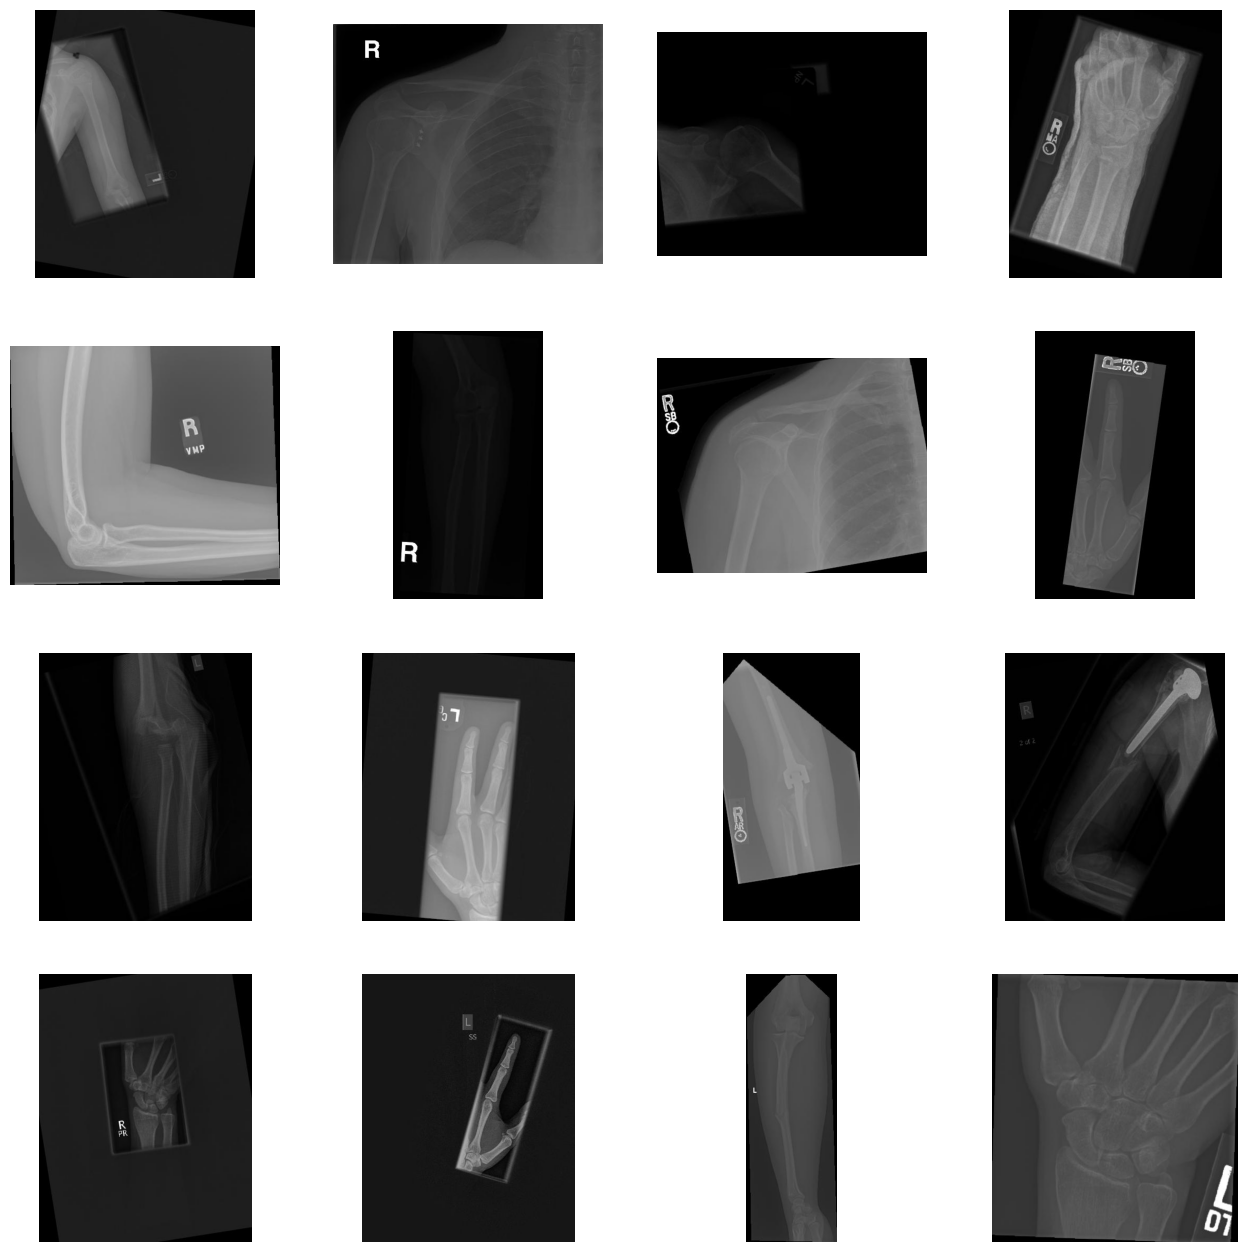

In [9]:
# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4

    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)


    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

In [16]:
# Loading a pretrained model
model = YOLO('yolov8s-obb.pt')

# Training the model
model.train(data = '/content/BoneFractureYolo8/data.yaml', task='detect', mode='train', epochs=35, batch=50, seed = 42)

100%|██████████| 22.2M/22.2M [00:00<00:00, 172MB/s]


Ultralytics 8.3.61 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=obb, mode=train, model=yolov8s-obb.pt, data=/content/BoneFractureYolo8/data.yaml, epochs=35, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

train: Scanning /content/BoneFractureYolo8/train/labels.cache... 3631 images, 1827 backgrounds, 0 corrupt: 100%|██████████| 3631/3631 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/BoneFractureYolo8/valid/labels.cache... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:00<?, ?it/s]


Plotting labels to runs/obb/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/obb/train2
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      15.6G      2.027      6.838      2.548         19       1024: 100%|██████████| 227/227 [03:08<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:08<00:00,  2.62it/s]

                   all        348        204      0.347      0.144      0.155     0.0659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/35      10.4G      1.863      3.555      2.448         11       1024: 100%|██████████| 227/227 [03:06<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]

                   all        348        204      0.344       0.15      0.176     0.0673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/35      10.3G      1.845      3.057      2.483         15       1024: 100%|██████████| 227/227 [03:03<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:08<00:00,  2.64it/s]

                   all        348        204      0.264      0.228      0.214     0.0924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35      10.4G      1.831       2.78      2.487         20       1024: 100%|██████████| 227/227 [03:01<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.75it/s]

                   all        348        204      0.514      0.296      0.266      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      10.7G      1.774      2.571      2.471         20       1024: 100%|██████████| 227/227 [03:05<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.62it/s]

                   all        348        204      0.199       0.35      0.266      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/35      10.3G      1.717      2.409      2.481         15       1024: 100%|██████████| 227/227 [03:06<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:08<00:00,  2.69it/s]

                   all        348        204      0.366      0.366      0.303      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/35      10.3G      1.671      2.164      2.413         17       1024: 100%|██████████| 227/227 [03:06<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.51it/s]

                   all        348        204      0.376      0.311      0.291      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/35      10.3G      1.598      1.971      2.351         12       1024: 100%|██████████| 227/227 [03:05<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]

                   all        348        204      0.334      0.365      0.295      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/35      10.7G      1.565      1.914      2.354         24       1024: 100%|██████████| 227/227 [03:04<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:08<00:00,  2.49it/s]

                   all        348        204      0.431      0.294       0.32      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/35      10.3G      1.511      1.753      2.292         23       1024: 100%|██████████| 227/227 [03:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.62it/s]

                   all        348        204      0.429      0.353      0.334      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/35      10.3G      1.473      1.653      2.283          8       1024: 100%|██████████| 227/227 [03:04<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.77it/s]

                   all        348        204      0.328       0.31       0.29      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35      10.3G      1.416      1.582      2.202         11       1024: 100%|██████████| 227/227 [03:02<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.28it/s]

                   all        348        204      0.482      0.337      0.345      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35      10.7G        1.4      1.464      2.204         14       1024: 100%|██████████| 227/227 [03:03<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.10it/s]

                   all        348        204      0.393      0.394      0.347      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/35      10.3G      1.342      1.339      2.158         15       1024: 100%|██████████| 227/227 [03:05<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:05<00:00,  3.71it/s]

                   all        348        204      0.374       0.37      0.342      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      10.3G      1.305      1.283      2.131         13       1024: 100%|██████████| 227/227 [03:04<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.77it/s]

                   all        348        204      0.401      0.399       0.34      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/35      10.3G      1.287      1.242      2.096         16       1024: 100%|██████████| 227/227 [03:04<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:08<00:00,  2.68it/s]

                   all        348        204       0.44      0.411      0.375      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/35      10.7G       1.25      1.178      2.107         19       1024: 100%|██████████| 227/227 [03:02<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.32it/s]

                   all        348        204      0.409      0.407      0.342      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/35      10.3G        1.2      1.087       2.03          9       1024: 100%|██████████| 227/227 [03:05<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.25it/s]

                   all        348        204      0.389      0.448      0.368      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/35      10.3G      1.162      1.034      2.006         16       1024: 100%|██████████| 227/227 [03:02<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.85it/s]

                   all        348        204      0.446      0.418      0.362      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/35      10.3G      1.146      1.016      1.996         17       1024: 100%|██████████| 227/227 [03:05<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]

                   all        348        204      0.458      0.359       0.36      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/35      10.3G      1.117     0.9476       1.94         18       1024: 100%|██████████| 227/227 [03:03<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:05<00:00,  3.71it/s]

                   all        348        204       0.45      0.371      0.372      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/35      10.3G      1.084     0.9458      1.926         17       1024: 100%|██████████| 227/227 [03:01<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.62it/s]

                   all        348        204      0.433      0.407      0.367      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35      10.3G      1.058     0.8996      1.899         22       1024: 100%|██████████| 227/227 [03:12<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.62it/s]

                   all        348        204      0.427      0.479      0.382      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/35      10.4G       1.02     0.8441      1.851         16       1024: 100%|██████████| 227/227 [03:05<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.22it/s]

                   all        348        204      0.452      0.403      0.379      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35      10.3G      1.007     0.8338      1.857         23       1024: 100%|██████████| 227/227 [03:04<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.98it/s]

                   all        348        204      0.482      0.316      0.343      0.175


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/35      10.3G     0.8698     0.6226      1.799         12       1024: 100%|██████████| 227/227 [02:53<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.83it/s]

                   all        348        204      0.461      0.388      0.365      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/35      10.3G     0.8311     0.5608      1.745          7       1024: 100%|██████████| 227/227 [02:55<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.21it/s]

                   all        348        204      0.454      0.407      0.373      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/35      10.4G     0.8194     0.5406      1.732         12       1024: 100%|██████████| 227/227 [02:55<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.54it/s]

                   all        348        204      0.449      0.413      0.387      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/35      10.3G     0.7955     0.5412      1.696          8       1024: 100%|██████████| 227/227 [02:54<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:05<00:00,  3.79it/s]

                   all        348        204      0.483      0.375      0.377      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/35      10.3G     0.7541     0.4828      1.624         10       1024: 100%|██████████| 227/227 [02:50<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.91it/s]

                   all        348        204      0.447      0.393      0.364      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/35      10.3G     0.7411     0.4823       1.62          7       1024: 100%|██████████| 227/227 [02:54<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.12it/s]

                   all        348        204      0.474      0.406       0.38      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/35      10.3G     0.7122     0.4574      1.585         14       1024: 100%|██████████| 227/227 [02:54<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:05<00:00,  3.77it/s]

                   all        348        204       0.48      0.388      0.379      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/35      10.7G     0.6888     0.4496      1.558          9       1024: 100%|██████████| 227/227 [02:55<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.19it/s]

                   all        348        204      0.508      0.426      0.393      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/35      10.3G     0.6719     0.4333       1.54          5       1024: 100%|██████████| 227/227 [02:50<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.55it/s]

                   all        348        204       0.48      0.364      0.378        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/35      10.3G     0.6657     0.4198       1.54          6       1024: 100%|██████████| 227/227 [02:54<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.99it/s]

                   all        348        204      0.494      0.377      0.371      0.196



35 epochs completed in 1.849 hours.
Optimizer stripped from runs/obb/train2/weights/last.pt, 23.3MB
Optimizer stripped from runs/obb/train2/weights/best.pt, 23.3MB

Validating runs/obb/train2/weights/best.pt...
Ultralytics 8.3.61 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-obb summary (fused): 187 layers, 11,414,280 parameters, 0 gradients, 29.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:08<00:00,  2.50it/s]


                   all        348        204      0.517      0.425       0.39      0.206
        elbow positive         28         29      0.469      0.345      0.247     0.0987
      fingers positive         41         48      0.457      0.312       0.26      0.121
      forearm fracture         37         43      0.722      0.628      0.692      0.409
               humerus         31         36      0.861      0.688      0.769      0.443
     shoulder fracture         19         20      0.398      0.397      0.262      0.122
        wrist positive         17         28      0.198      0.179      0.113     0.0398
Speed: 0.6ms preprocess, 10.0ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/obb/train2


ultralytics.utils.metrics.OBBMetrics object with attributes:

ap_class_index: array([0, 1, 2, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7eb4692902e0>
curves: []
curves_results: []
fitness: 0.22408887914178965
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([   0.098729,     0.12061,     0.40878,      0.2056,     0.44327,     0.12245,    0.039783])
names: {0: 'elbow positive', 1: 'fingers positive', 2: 'forearm fracture', 3: 'humerus fracture', 4: 'humerus', 5: 'shoulder fracture', 6: 'wrist positive'}
plot: True
results_dict: {'metrics/precision(B)': 0.517411136066175, 'metrics/recall(B)': 0.42473734648486366, 'metrics/mAP50(B)': 0.3904612305054879, 'metrics/mAP50-95(B)': 0.20560306232360095, 'fitness': 0.22408887914178965}
save_dir: PosixPath('runs/obb/train2')
speed: {'preprocess': 0.5565141809397731, 'inference': 9.960581516397411, 'loss': 

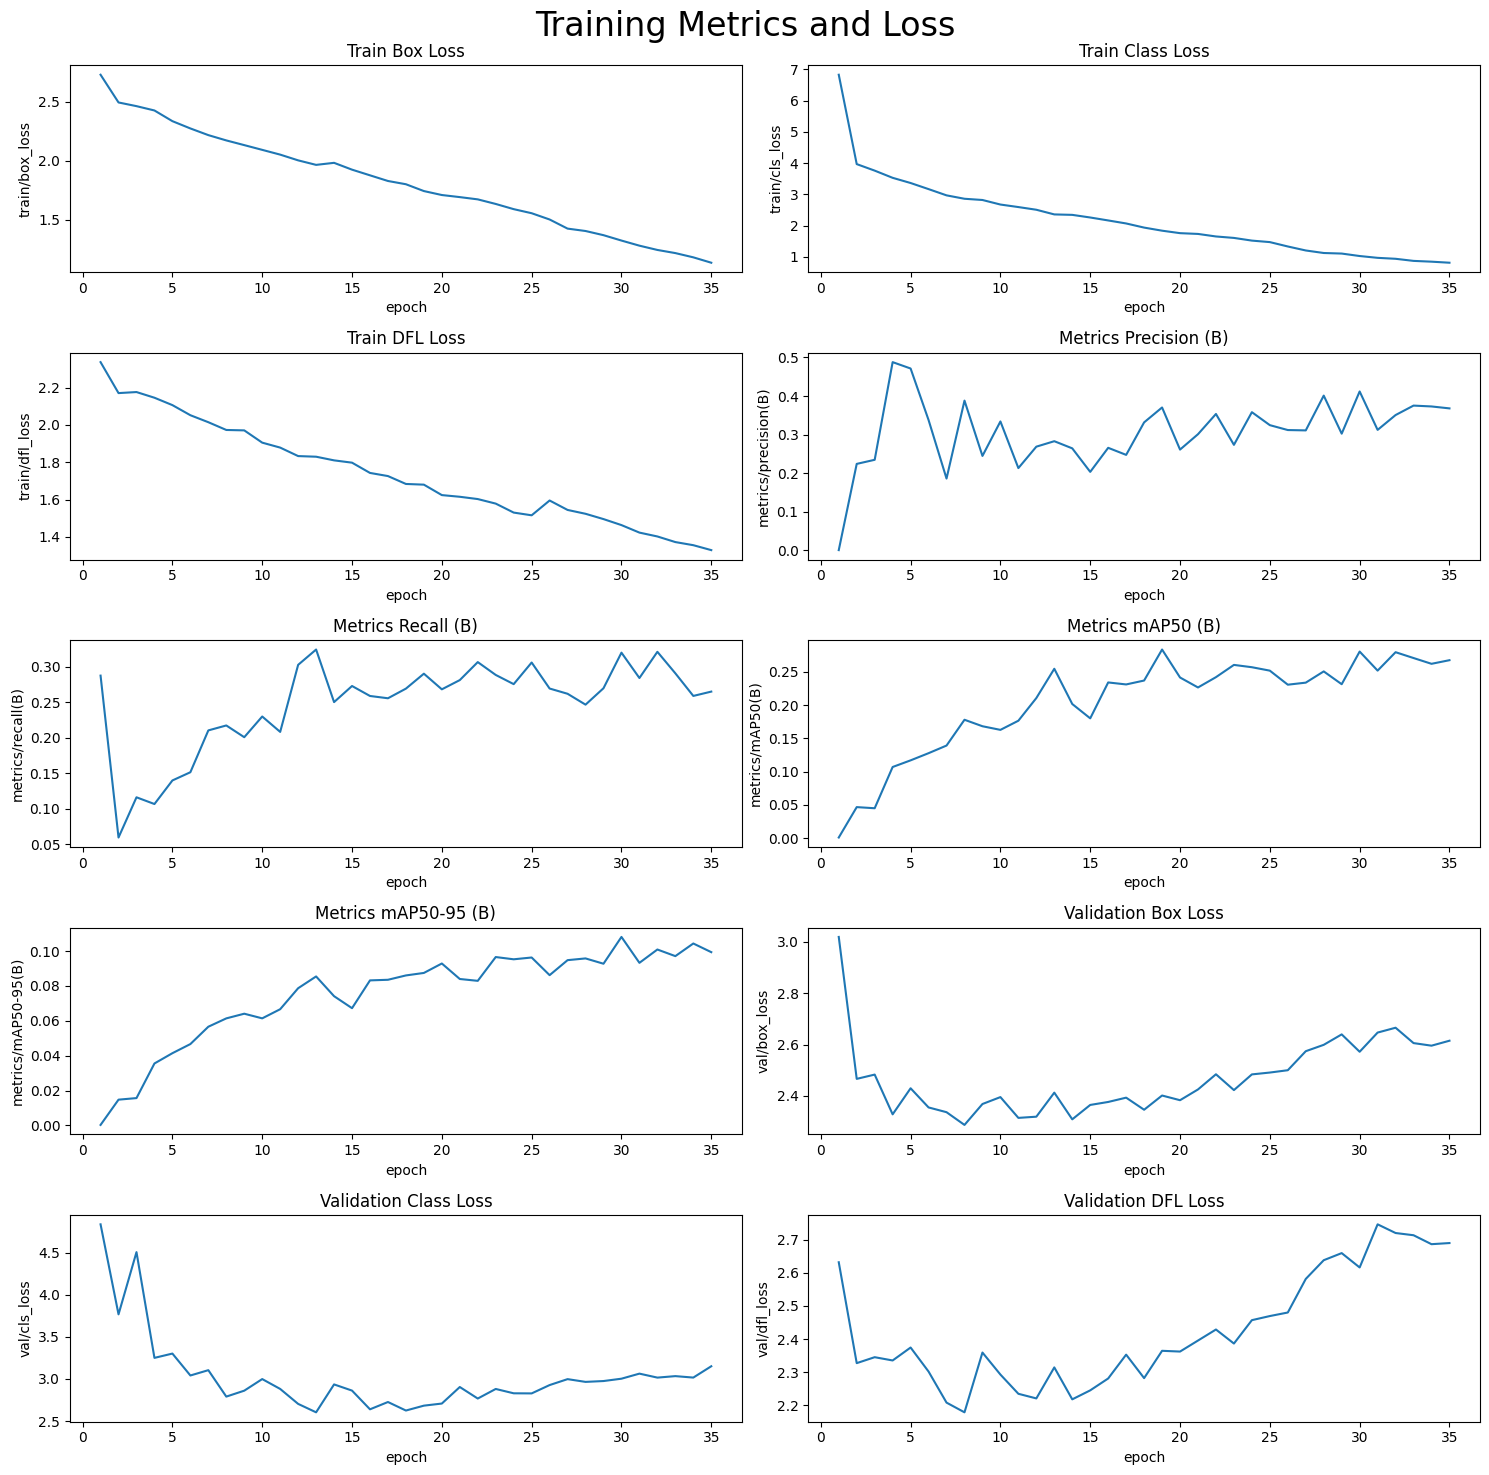

In [17]:
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('runs/detect/train/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

In [19]:
# Loading the best performing model
model = YOLO('runs/obb/train2/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics 8.3.61 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-obb summary (fused): 187 layers, 11,414,280 parameters, 0 gradients, 29.4 GFLOPs


val: Scanning /content/BoneFractureYolo8/test/labels.cache... 169 images, 86 backgrounds, 0 corrupt: 100%|██████████| 169/169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


                   all        169         96      0.509      0.228      0.356      0.188
        elbow positive         13         17        0.2     0.0588      0.113     0.0453
      fingers positive         22         27      0.462      0.222      0.286       0.11
      forearm fracture         13         14        0.8      0.286      0.571        0.4
               humerus         14         15      0.667        0.4      0.533      0.285
     shoulder fracture         15         17        0.8      0.235      0.541      0.215
        wrist positive          6          6      0.127      0.167     0.0935     0.0748
Speed: 2.0ms preprocess, 37.6ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to runs/obb/val


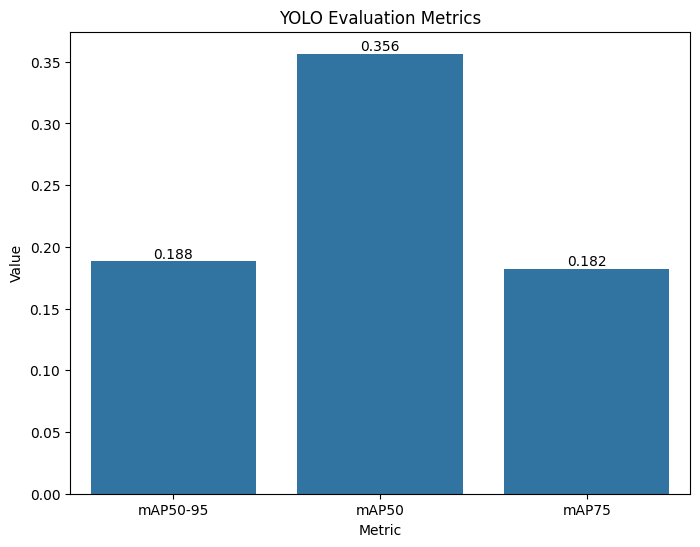

In [20]:
%matplotlib inline
# Create the barplot
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Show the plot
plt.show()

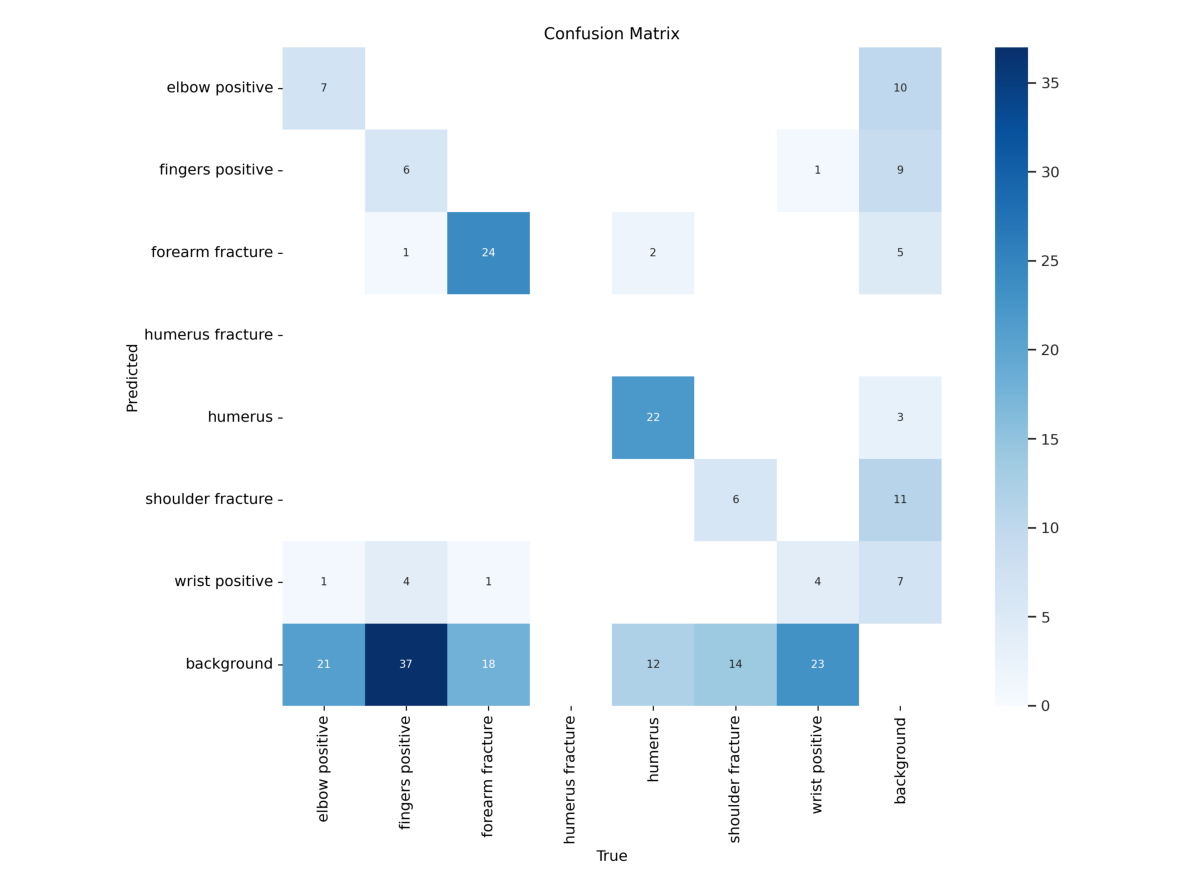

In [22]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('runs/obb/train2/confusion_matrix.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');